In [1]:
#import necessary libraries
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import tensorflow.compat.v1 as tf #ensure no tf version compatibility issues
tf.disable_v2_behavior() 
tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

2024-11-27 17:59:14.625563: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 17:59:14.650790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 17:59:14.650821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 17:59:14.650833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 17:59:14.656216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 17:59:14.656985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
#import California dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
# Load the California Housing dataset
data = fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the dataset
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

print(X_train.shape) #debugging
print(len(X_train))

(16512, 8)
16512


In [23]:
# NN parameters
n_ensemble = 10	# no. of NNs in ensemble
reg = 'anc'		# type of regularisation to use - anc (anchoring) reg (regularised) free (unconstrained)
n_hidden = 50 	# no. hidden units in NN
activation_in = 'relu' # tanh relu sigmoid
data_noise = 0.001 # estimated noise variance
n_data = len(X_train) #total no of points in training dataset
n_features = X_train.shape[1] #no of features
#print(n_features)#Debugging
 
# optimisation options
epochs = 75		# run reg for 15+ epochs seems to mess them up
l_rate = 0.001 		# learning rate

# variance of priors
W1_var = 20/1		# 1st layer weights and biases
W_mid_var = 1/n_hidden	# 2nd layer weights and biases
W_last_var = 1/n_hidden	# 3rd layer weights

In [24]:
#Creating Neural Networks
# NN object-3layers
def fn_make_NN(reg='anc', activation_in='relu'):

	# get initialisations, and regularisation values
	W1_lambda = data_noise/W1_var
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])

	b1_var = W1_var
	b1_lambda =  data_noise/b1_var
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = data_noise/W_mid_var
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  data_noise/b_mid_var
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = data_noise/W_last_var
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_features,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))

	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))

	model.add(Dense(1, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss='mean_squared_error', 
		optimizer=keras.optimizers.Adam(learning_rate=l_rate))

	return model


def fn_predict_ensemble(NNs, x_test):
	''' fn to predict given a list of NNs (an ensemble)''' 
	y_preds = []
	for m in range(len(NNs)):
		y_preds.append(NNs[m].predict(x_test, verbose=0))
	y_preds = np.array(y_preds)

	y_preds_mu = np.mean(y_preds,axis=0)
	y_preds_std = np.std(y_preds,axis=0)

	return y_preds, y_preds_mu, y_preds_std

In [25]:
# NN object-increase depth1
def fn_make_NNd1(reg='anc', activation_in='relu'):

	# get initialisations, and regularisation values
	W1_lambda = data_noise/W1_var
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])

	b1_var = W1_var
	b1_lambda =  data_noise/b1_var
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = data_noise/W_mid_var
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  data_noise/b_mid_var
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = data_noise/W_last_var
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_features,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))

	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(1, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss='mean_squared_error', 
		optimizer=keras.optimizers.Adam(learning_rate=l_rate))

	return model


In [58]:
# NN object-increase depth2-intermediate
def fn_make_NNd2(reg='anc', activation_in='relu'):

	# get initialisations, and regularisation values
	W1_lambda = data_noise/W1_var
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])

	b1_var = W1_var
	b1_lambda =  data_noise/b1_var
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = data_noise/W_mid_var
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  data_noise/b_mid_var
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = data_noise/W_last_var
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_features,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(1, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss='mean_squared_error', 
		optimizer=keras.optimizers.Adam(learning_rate=l_rate))

	return model


In [65]:
# NN object-increase depth3-intermediate
def fn_make_NNd3(reg='anc', activation_in='relu'):

	# get initialisations, and regularisation values
	W1_lambda = data_noise/W1_var
	W1_anc = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])
	W1_init = np.random.normal(loc=0,scale=np.sqrt(W1_var),size=[n_features,n_hidden])

	b1_var = W1_var
	b1_lambda =  data_noise/b1_var
	b1_anc = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])
	b1_init = np.random.normal(loc=0,scale=np.sqrt(b1_var),size=[n_hidden])

	W_mid_lambda = data_noise/W_mid_var
	W_mid_anc = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])
	W_mid_init = np.random.normal(loc=0,scale=np.sqrt(W_mid_var),size=[n_hidden,n_hidden])

	b_mid_var = W_mid_var
	b_mid_lambda =  data_noise/b_mid_var
	b_mid_anc = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
	b_mid_init = np.random.normal(loc=0,scale=np.sqrt(b_mid_var),size=[n_hidden])
    
	W_last_lambda = data_noise/W_last_var
	W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])
	W_last_init = np.random.normal(loc=0,scale=np.sqrt(W_last_var),size=[n_hidden, 1])

	# create custom regularised
	def custom_reg_W1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W1_anc)) * W1_lambda/n_data

	def custom_reg_b1(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b1_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b1_anc)) * b1_lambda/n_data

	def custom_reg_W_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_mid_anc)) * W_mid_lambda/n_data

	def custom_reg_b_mid(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * b_mid_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - b_mid_anc)) * b_mid_lambda/n_data

	def custom_reg_W_last(weight_matrix):
		if reg == 'reg':
			return K.sum(K.square(weight_matrix)) * W_last_lambda/n_data
		elif reg == 'free':
			return 0.
		elif reg == 'anc':
			return K.sum(K.square(weight_matrix - W_last_anc)) * W_last_lambda/n_data

	model = Sequential()
	model.add(Dense(n_hidden, activation=activation_in, input_shape=(n_features,),
		kernel_initializer=keras.initializers.Constant(value=W1_init),
		bias_initializer=keras.initializers.Constant(value=b1_init),
		kernel_regularizer=custom_reg_W1,
		bias_regularizer=custom_reg_b1))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(n_hidden, activation=activation_in,
		kernel_initializer=keras.initializers.Constant(value=W_mid_init),
		bias_initializer=keras.initializers.Constant(value=b_mid_init),
		kernel_regularizer=custom_reg_W_mid,
		bias_regularizer=custom_reg_b_mid))
	
	model.add(Dense(1, activation='linear',use_bias=False,
		kernel_initializer=keras.initializers.Constant(value=W_last_init),
		kernel_regularizer=custom_reg_W_last))

	model.compile(loss='mean_squared_error', 
		optimizer=keras.optimizers.Adam(learning_rate=l_rate))

	return model

In [26]:
# create the NNs
NNs=[]
for m in range(n_ensemble):
	NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
print(NNs[-1].summary())

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 50)                450       
                                                                 
 dense_118 (Dense)           (None, 50)                2550      
                                                                 
 dense_119 (Dense)           (None, 1)                 50        
                                                                 
Total params: 3050 (11.91 KB)
Trainable params: 3050 (11.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [27]:
# do training
NNs_hist_train=[];
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs[m].fit(X_train, y_train,
			  #batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
	NNs_hist_train.append(hist.history['loss'])

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_88563/2879326500.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


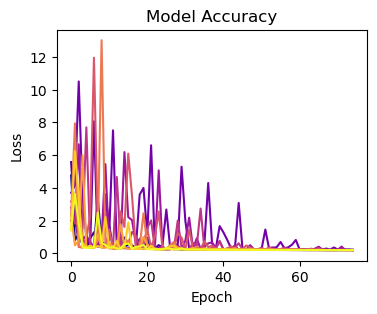

In [74]:
# check how training looked
NNs_hist_train=np.array(NNs_hist_train)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
COLORNUM = colors = plt.cm.plasma(np.linspace(0, 1, n_ensemble))
for m in range(n_ensemble):
    ax.plot(NNs_hist_train[m], color=COLORNUM[m],label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Accuracy')
fig.show()

In [32]:
# run predictions
y_preds1, y_preds_mu1, y_preds_std1 = fn_predict_ensemble(NNs,X_test)
#print(y_preds1.shape)#debug

(10, 4128, 1)


In [36]:
# create the NNs- increased depth
NNs_deep=[]
for m in range(n_ensemble):
	NNs_deep.append(fn_make_NNd1(reg=reg, activation_in=activation_in))
print(NNs_deep[-1].summary())

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 50)                450       
                                                                 
 dense_184 (Dense)           (None, 50)                2550      
                                                                 
 dense_185 (Dense)           (None, 50)                2550      
                                                                 
 dense_186 (Dense)           (None, 50)                2550      
                                                                 
 dense_187 (Dense)           (None, 50)                2550      
                                                                 
 dense_188 (Dense)           (None, 50)                2550      
                                                                 
 dense_189 (Dense)           (None, 1)               

In [37]:
# do training
NNs_hist_train2=[]
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs_deep[m].fit(X_train, y_train,
			  #batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
	NNs_hist_train2.append(hist.history['loss'])

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_88563/3009257812.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


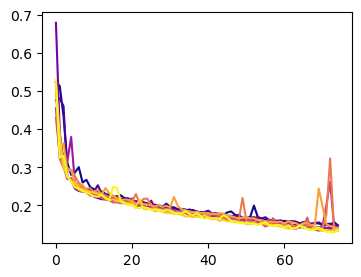

In [38]:
# check how training looked
NNs_hist_train2=np.array(NNs_hist_train2)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
COLORNUM = colors = plt.cm.plasma(np.linspace(0, 1, n_ensemble))
for m in range(n_ensemble):
    ax.plot(NNs_hist_train2[m], color=COLORNUM[m],label='train')
fig.show()

In [39]:
# run predictions
y_preds2, y_preds_mu2, y_preds_std2 = fn_predict_ensemble(NNs_deep,X_test)

In [ ]:
#Compare uncertainties in prediction
compare = np.zeros(len(X_test))
for i in np.arange(len(X_test)):
    if (y_preds_std1[i]>y_preds_std2[i]):
        compare[i] = 1

In [57]:
frac = np.sum(compare)/len(X_test)
print(frac)

0.39825581395348836
4128
4128


In [60]:
#NN3
NNs_deep2=[]
for m in range(n_ensemble):
	NNs_deep2.append(fn_make_NNd2(reg=reg, activation_in=activation_in))
print(NNs_deep2[-1].summary())

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_285 (Dense)           (None, 50)                450       
                                                                 
 dense_286 (Dense)           (None, 50)                2550      
                                                                 
 dense_287 (Dense)           (None, 50)                2550      
                                                                 
 dense_288 (Dense)           (None, 50)                2550      
                                                                 
 dense_289 (Dense)           (None, 1)                 50        
                                                                 
Total params: 8150 (31.84 KB)
Trainable params: 8150 (31.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [61]:
# do training
NNs_hist_train3=[]
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs_deep2[m].fit(X_train, y_train,
			  #batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
	NNs_hist_train3.append(hist.history['loss'])

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_88563/3384959273.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


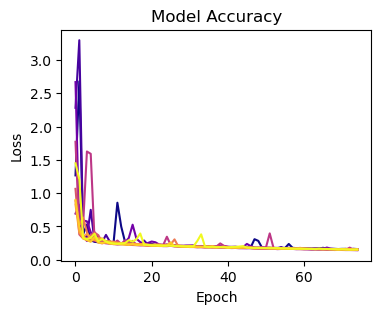

In [75]:
# check how training looked
NNs_hist_train3=np.array(NNs_hist_train3)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
COLORNUM = colors = plt.cm.plasma(np.linspace(0, 1, n_ensemble))
for m in range(n_ensemble):
    ax.plot(NNs_hist_train3[m], color=COLORNUM[m],label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Accuracy')
fig.show()

In [63]:
y_preds3, y_preds_mu3, y_preds_std3 = fn_predict_ensemble(NNs_deep2,X_test)

In [73]:
#Compare uncertainties in prediction
compare2 = np.zeros(len(X_test))
for i in np.arange(len(X_test)):
    if (y_preds_std1[i]>y_preds_std3[i]):
        compare2[i] = 1
frac2 = np.sum(compare2)/len(X_test)
print(frac2)

0.35683139534883723


In [67]:
#NN4
NNs_deep3=[]
for m in range(n_ensemble):
	NNs_deep3.append(fn_make_NNd3(reg=reg, activation_in=activation_in))
print(NNs_deep3[-1].summary())

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_366 (Dense)           (None, 50)                450       
                                                                 
 dense_367 (Dense)           (None, 50)                2550      
                                                                 
 dense_368 (Dense)           (None, 50)                2550      
                                                                 
 dense_369 (Dense)           (None, 1)                 50        
                                                                 
Total params: 5600 (21.88 KB)
Trainable params: 5600 (21.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [68]:
# do training
NNs_hist_train4=[]
for m in range(n_ensemble):
	print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
	hist = NNs_deep3[m].fit(X_train, y_train,
			  #batch_size=n_data,
			  epochs=epochs,
			  verbose=0)
	NNs_hist_train4.append(hist.history['loss'])

-- training: 1 of 10 NNs --
-- training: 2 of 10 NNs --
-- training: 3 of 10 NNs --
-- training: 4 of 10 NNs --
-- training: 5 of 10 NNs --
-- training: 6 of 10 NNs --
-- training: 7 of 10 NNs --
-- training: 8 of 10 NNs --
-- training: 9 of 10 NNs --
-- training: 10 of 10 NNs --


/tmp/ipykernel_88563/3384959273.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


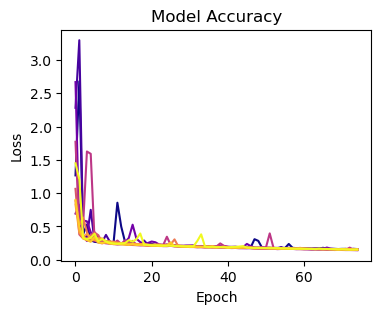

In [76]:
# check how training looked
NNs_hist_train3=np.array(NNs_hist_train3)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
COLORNUM = colors = plt.cm.plasma(np.linspace(0, 1, n_ensemble))
for m in range(n_ensemble):
    ax.plot(NNs_hist_train3[m], color=COLORNUM[m],label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Accuracy')
fig.show()

In [70]:
#prediction
y_preds4, y_preds_mu4, y_preds_std4 = fn_predict_ensemble(NNs_deep3,X_test)

In [72]:
#Compare uncertainties in prediction
compare3 = np.zeros(len(X_test))
for i in np.arange(len(X_test)):
    if (y_preds_std1[i]>y_preds_std4[i]):
        compare3[i] = 1
frac3 = np.sum(compare3)/len(X_test)
print(frac3)

0.38856589147286824
